In [1]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
from astropy.cosmology import Planck15 as cosmo

# adding path to GPR_for_IM directory in order to import relevant scripts
import sys
sys.path.append('../')
import pk_tools as pk
import fg_tools as fg
import obs_tools as obs

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

### Loading data:

In [3]:
FGnopol_data = (np.load('../Data/dT_sync_Stripe82_noBeam.npy')
                + np.load('../Data/dT_free_Stripe82_noBeam.npy')
                + np.load('../Data/dT_psource_Stripe82_noBeam.npy'))
HI_data = np.load('../Data/T_HI-MDSAGE_z_0.39.npy')
HI_data = np.swapaxes(HI_data, 1, 2)
noise_data = np.load('../Data/dT_noise.npy')

Smooth maps by a constant Gaussian telescope beam:

In [4]:
# smoothing maps
lx,ly,lz = 1000,1000, 924.78 #Mpc/h
zmax = 0.58
sigma_beam = 1.55
FGnopol_HI_noise_smoothed = obs.ConvolveCube(FGnopol_data+HI_data+noise_data,zmax,lx,ly,sigma_beam, cosmo)
HI_noise_smoothed = obs.ConvolveCube(HI_data+noise_data,zmax,lx,ly,sigma_beam, cosmo)
noise_smoothed = obs.ConvolveCube(noise_data,zmax,lx,ly,sigma_beam, cosmo)

Perform PCA removal of data, to compare with GPR:

In [5]:
pca_res_nopol3 = fg.PCAclean(FGnopol_HI_noise_smoothed, N_FG=3)[0]
pca_res_nopol2 = fg.PCAclean(FGnopol_HI_noise_smoothed, N_FG=2)[0]

Frequency range of data:

In [6]:
df = 1 # frequency resolution of data (MHz)
vmin = 899 # min frequency (MHz)
vmax = 1184 # max frequency (MHz)
freqs = np.arange(vmin, vmax, df)

### Running GPR

In [17]:
# Choose your kernels, one for FG and one for HI signal
kern_fg = GPy.kern.Poly(1, order=5)
kern_21 = GPy.kern.Exponential(1)
gpr_res, gpr_cov, model = fg.GPRclean(FGnopol_HI_noise_smoothed, freqs, kern_fg, kern_21, NprePCA=0, 
                                      noise_data=noise_smoothed, heteroscedastic=True, zero_noise=False, invert=True)

Optimization restart 1/10, f = -46914208.80378945
Optimization restart 2/10, f = -46914209.45448348
Optimization restart 3/10, f = -46914210.01099205
Optimization restart 4/10, f = 10012294.498236826
Optimization restart 5/10, f = -36882535.06011365
Optimization restart 6/10, f = -46914209.24377583
Optimization restart 7/10, f = -46914207.41260108
Optimization restart 8/10, f = -34570347.35862382
Optimization restart 9/10, f = -41074375.53469527
Optimization restart 10/10, f = 4727179.184861225


### Plot power spectra

In [18]:
# Dimension of data cube:
nx,ny,nz = 256, 256, 285
# Measure the auto-power spectrum, with noise:
kmin = 2*np.pi/pow(lx*ly*lz, 1/3)
kmax= 1
dk = 2*kmin
nkbin = int((kmax-kmin)/dk)
kbins = np.arange(kmin,kmax,dk)
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
# weighting and window function:
w = W = np.ones((nx,ny,nz))

Calculating power spectrum of different foreground removal techniques, and original data:

In [19]:
HIpk = pk.getpk(HI_noise_smoothed,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
PCApk_3 = pk.getpk(pca_res_nopol3,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
PCApk_2 = pk.getpk(pca_res_nopol2,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
GPRpk = pk.getpk(gpr_res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

Text(0.5, 0, 'k [$h$/Mpc]')

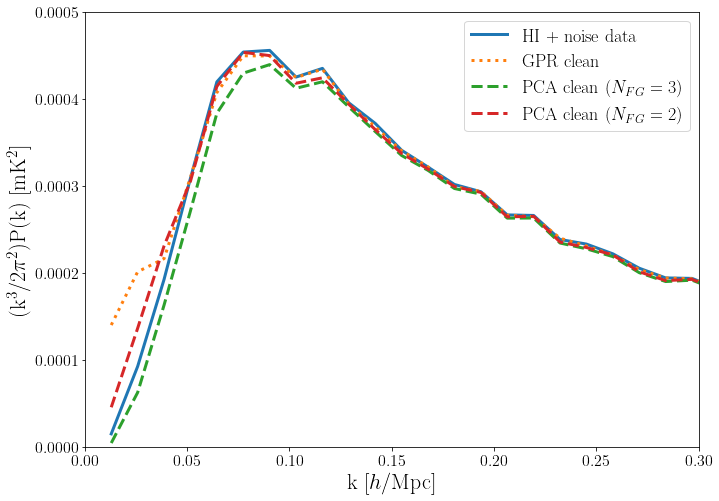

In [20]:
plt.figure(figsize=(11,8))
plt.plot(k, (k*k*k*HIpk)/(2*np.pi*np.pi),ls='solid', lw=3, label = r'HI + noise data')
plt.plot(k, (k*k*k*GPRpk)/(2*np.pi*np.pi),ls='dotted', lw=3, label = r'GPR clean')
plt.plot(k, (k*k*k*PCApk_3)/(2*np.pi*np.pi),ls='dashed', lw=3, label = r'PCA clean ($N_{FG}=3$)')
plt.plot(k, (k*k*k*PCApk_2)/(2*np.pi*np.pi),ls='dashed', lw=3, label = r'PCA clean ($N_{FG}=2$)')

plt.legend(fontsize=18)
plt.xlim(0,0.3)
plt.ylim(0,0.0005)
plt.ylabel('(k$^3$/2$\pi^2$)P(k) [mK$^2$]', fontsize=22)
plt.xlabel('k [$h$/Mpc]', fontsize=22)

Plotting difference between true power spectrum of HI+noise and recovered power spectra from different foreground removal techniques.

Text(0.5, 0, 'k [$h$/Mpc]')

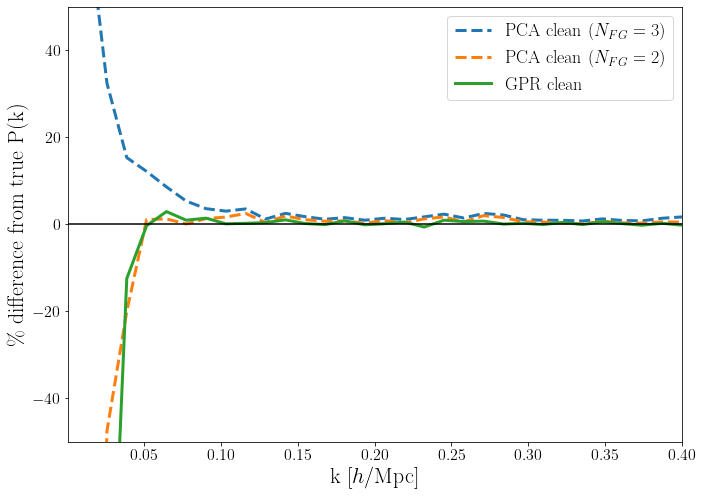

In [21]:
plt.figure(figsize=(11,8))

plt.plot(k, 100*(HIpk-PCApk_3)/HIpk, lw=3, ls='dashed', label='PCA clean ($N_{FG}=3$)')
plt.plot(k, 100*(HIpk-PCApk_2)/HIpk, lw=3, ls='dashed', label='PCA clean ($N_{FG}=2$)')
plt.plot(k, 100*(HIpk-GPRpk)/HIpk, lw=3, label='GPR clean')

plt.legend(fontsize=18)
plt.axhline(0, c='k')
plt.xlim(0.0005,0.4)
plt.ylim(-100*0.5, 100*0.5)
plt.ylabel('\% difference from true P(k)', fontsize=22)
plt.xlabel('k [$h$/Mpc]', fontsize=22)